In [2]:
import gymnasium as gym

from stable_baselines3 import SAC, DDPG, PPO


from environment import *
from env_wrappers import *
from matplotlib import pyplot as plt
from general_utils import *
from delay_model import *
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import torch
from wc_sac import *
from stable_baselines3.common.logger import Logger, configure
import datetime
import copy
from test_utils import *
from train_utils import *
from orchestrator import *
import pandas as pd
from safe_sac import SafeSAC

%load_ext autoreload
%autoreload 2

plt.rcParams['font.family'] = 'serif'

In [59]:
core_env = NonLinearVelocity(desired_state=np.array([2.6131]))
tank_agent, tank_env = train_default_sac(core_env = core_env, desired_state=2.6131, seed = 0, n_episodes = 200, observation_type='setpoint-error', randomise_setpoint=True)

Wrapping in random setpoint
Regions limits are [[array([0.2]), array([1.06666667])], [array([1.06666667]), array([1.93333333])], [array([1.93333333]), array([2.8])]]
Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/NonLinearVelocity/setpoint-error/randomised/0613/Desired2.6131/sac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -139     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 29       |
|    time_elapsed    | 16       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 1.82     |
|    critic_loss     | 0.00909  |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\NonLinearVelocity\setpoint-error\randomised\Desired2.6131' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Initial state was [1.8 1.4]
Bias: [-0.03245834]


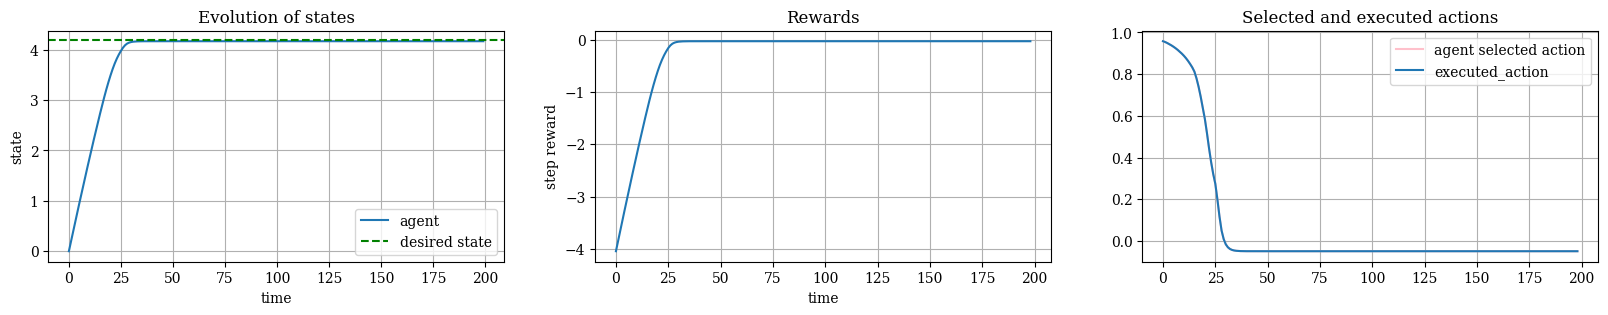

In [70]:
test_env = NonLinearVelocity(start_state=np.array([0.0]), desired_state=np.array([4.2]), max_episode_len=200)
test_env = init_wrappers(test_env, observation_type='setpoint-error')
test_env = DelayAction(test_env, delay = 0)

states, actions, rewards, avg, executed = test_agent(tank_agent, test_env, deterministic=True, state_error=True)
# start = 0
# stop = 120
# plt.plot((np.array(states))[start:stop])
# plt.axhline(test_env.unwrapped.desired_state, color = 'r', linestyle = '--')
# # plt.stairs(np.array(tank_env.unwrapped.desired_trajectory)[start:stop])
# plt.legend(['State', 'Desired'])
print(f"Bias: {states[-1] - test_env.unwrapped.desired_state}")
plot_test(test_env, states, rewards, actions, executed)

In [7]:
setpoints = [2.6142, 2.6143]
seeds = [42, 96]
agent_types = ['wcsac', 'safesac', 'augsac']

for i, seed in enumerate(seeds) :
  setpoint = setpoints[i]
  core_env = NonLinearVelocity(desired_state=np.array([setpoint]), seed = seed)
  agent, env = train_default_sac(core_env = core_env, desired_state=setpoint, seed = seed, n_episodes = 200, observation_type='setpoint-error', randomise_setpoint=True)
  for agent_type in agent_types: 
    if agent_type != 'wcsac' and seed == 42 :
      continue
    for avg_q in [True, False]:
      if avg_q == False and agent_type == 'augsac':
        continue
      
      safe_agent, env, delay_history, setpoint_history = train_default_augmented_sac(core_env = core_env, 
                                              agent_type= agent_type,
                                              desired_state= setpoint,
                                              seed = seed,
                                              observation_type='setpoint-error',
                                              randomise_setpoint=True, 
                                              random_delay=True,
                                              average_q=avg_q,
                                              n_episodes=200, 
                                              ent_coef=0.5,
                                              undelayed_critic=agent.critic)
      min_str = 'min' if not avg_q else ''
      np.save(f'histories/delay/{agent_type}{min_str}_seed{seed}_setpoint{setpoint}', delay_history)
      np.save(f'histories/setpoint/{agent_type}{min_str}_seed{seed}_setpoint{setpoint}', setpoint_history)
 





Wrapping in random setpoint
Regions limits are [[array([0.2]), array([1.06666667])], [array([1.06666667]), array([1.93333333])], [array([1.93333333]), array([2.8])]]
Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/NonLinearVelocity/setpoint-error/randomised/0614/Desired2.6142/sac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -118     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 30       |
|    time_elapsed    | 15       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 1.4      |
|    critic_loss     | 0.0141   |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.state_space_violation to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state_space_violation` for environment variables or `env.get_wrapper_attr('state_space_violation')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -175     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 15       |
|    time_elapsed    | 30       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 2.32     |
|    critic_loss     | 0.108    |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -162     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 14       |
|    time_elapsed    | 67       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 4.77     |
|    critic_loss     | 0.0422   |
|    ent_coef        | 0.5      |
|    learning_

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.delay_history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.delay_history` for environment variables or `env.get_wrapper_attr('delay_history')` that will search the reminding wrappers.
  logger.warn(
c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.desired_states_history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desired_states_history` for environment variables or `env.get_wrapper_attr('desired_states_history')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -195     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 20       |
|    time_elapsed    | 23       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 2.56     |
|    critic_loss     | 0.0343   |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -144     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 18       |
|    time_elapsed    | 52       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 4.23     |
|    critic_loss     | 0.0489   |
|    ent_coef        | 0.5      |
|    learning_

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\NonLinearVelocity\setpoint-error\randomised\Desired2.6143' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -115     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 18       |
|    time_elapsed    | 25       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 0.876    |
|    critic_loss     | 0.0266   |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -144     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 17       |
|    time_elapsed    | 54       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 3.03     |
|    critic_loss     | 0.0236   |
|    ent_coef        | 0.5      |
|    learning_

In [3]:
np.save(f'histories/delay/{agent_type}{min_str}_seed{seed}_setpoint{setpoint}', delay_history)
np.save(f'histories/setpoint/{agent_type}{min_str}_seed{seed}_setpoint{setpoint}', setpoint_history)

Observing state without wrappers
Rescaling action
Rescaling observation


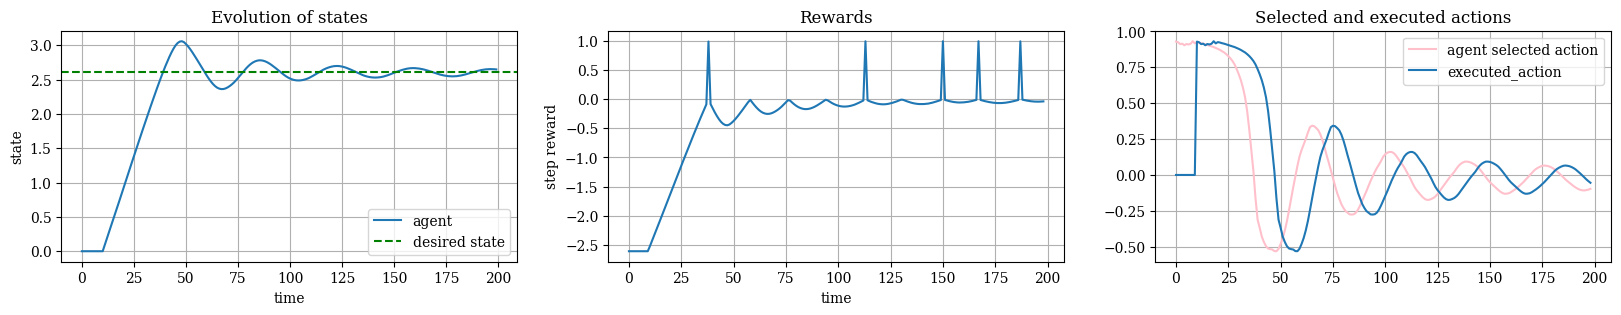

In [54]:
core_env = NonLinearVelocity(start_state=np.array([0.0]), desired_state=np.array([2.6131]), max_episode_len=200)

core_env = init_wrappers(core_env, observation_type='state', randomise_setpoint=False)
env = DelayAction(core_env, delay = 10, random_delay=False, max_delay=global_config.MAX_DELAY)
env = AugmentState(env, known_delay=global_config.MAX_DELAY)

states, actions, rewards, avg_rewards, executed = test_augmented_agent(safe_agent, env, deterministic=True, state_error=True)
plot_test(env, states, rewards, actions, executed )

In [23]:
setpoints = [2.6141, 2.6142, 2.6143]
dates = ['0614','0614','0615']
# dates = ['0614','0614','0614']
agent_types = ['sac','wcsac','wcsacmin','safesac','safesacmin','augsacsafe']

agent_dict = {}
for agent_type in agent_types:
    run_arr = []
    for i, setpoint in enumerate(setpoints) : 
        df = pd.read_csv(f'logs\\train\\NonLinearVelocity\\setpoint-error\\randomised\\{dates[i]}\\Desired{setpoint}\\{agent_type}\\progress.csv')
        run_arr.append(np.array(df['rollout/ep_rew_mean']))

    agent_dict[agent_type] = run_arr

        
agent_dict

{'sac': [array([-142.386093  ,  -85.73154538,  -62.55277675,  -50.86597256,
          -43.3451112 ,  -37.85926317,  -34.64203582,  -31.44597509,
          -29.45533247,  -27.85559627,  -26.08050557,  -25.27620906,
          -24.08249437,  -23.57242377,  -22.90158988,  -22.31690977,
          -21.48839099,  -20.99808804,  -20.59115097,  -20.24932   ,
          -19.90663962,  -19.49011442,  -19.34359259,  -19.3590303 ,
          -19.01266061,  -13.83359719,  -12.94372108,  -13.05842003,
          -13.09404121,  -13.42597536,  -13.35249821,  -13.1037855 ,
          -13.32343066,  -13.30795334,  -13.31733073,  -13.55021479,
          -13.36497429,  -13.47415659,  -13.41837383,  -13.59958554,
          -13.60876288,  -13.80425037,  -14.03765262,  -14.07918244,
          -14.10131525,  -14.12449037,  -14.16360472,  -13.88389813,
          -13.5022285 ,  -13.63990928]),
  array([-118.183944  ,  -86.42264612,  -65.369305  ,  -53.46681169,
          -45.82593765,  -40.07818246,  -36.62039918,  

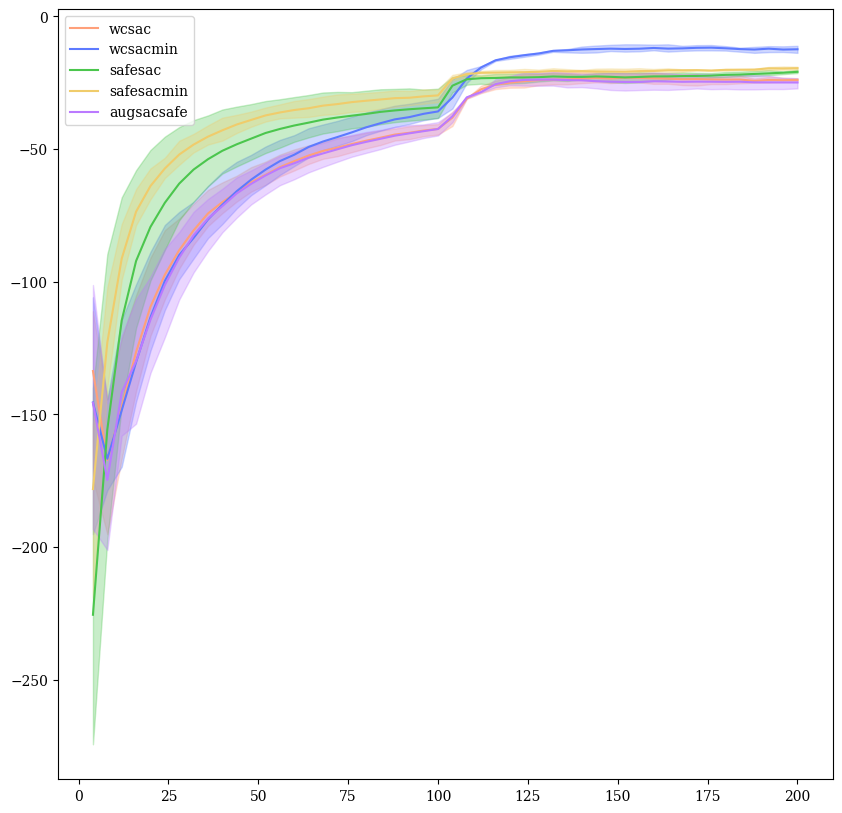

In [24]:
agent_types = ['wcsac','wcsacmin', 'safesac','safesacmin','augsacsafe']
colors = ['cold_orange', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']
# Plot 
f, ax = plt.subplots(1,1, figsize = (10,10))
for i, agent_type in enumerate(agent_types) : 
    res = np.array(agent_dict[agent_type])
    r_min = np.min(res, axis = 0)
    r_max = np.max(res, axis = 0)
    r_avg= np.mean(res, axis = 0)

    ax.plot(df['time/episodes'], r_avg, color = global_config.COLORS[colors[i]])
    ax.fill_between(df['time/episodes'], r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .3, label='_nolegend_')
# ax.legend([agent_types[i//2] if i%2 == 0 else '' for i in range(2*len(agent_types))]
ax.legend(agent_types)



# ax.plot(delayeddf['time/episodes'], avg_delayed_rewards, color = global_config.COLORS['cold_orange'])
# ax.plot(augdf['time/episodes'], avg_aug_rewards, color = global_config.COLORS['warm_blue'])
# ax.plot(safedf['time/episodes'], avg_safe_rewards, color = global_config.COLORS['warm_green'])
# ax.plot(safemindf['time/episodes'], avg_safemin_rewards, color = global_config.COLORS['warm_yellow'])
# ax.plot(wcmindf['time/episodes'], avg_wcmin_rewards, color = global_config.COLORS['warm_purple'])

# ax.fill_between(delayeddf['time/episodes'], dmin, dmax, color = global_config.COLORS['cold_orange'],  alpha = .3)
# ax.fill_between(augdf['time/episodes'], amin, amax, color = global_config.COLORS['warm_blue'], alpha = .3)
# ax.fill_between(safedf['time/episodes'], smin, smax, color = global_config.COLORS['warm_green'], alpha = .3)
# ax.fill_between(safemindf['time/episodes'], smmin, smmax, color = global_config.COLORS['warm_yellow'], alpha = .3)
# ax.fill_between(wcmindf['time/episodes'], wcmin, wcmax, color = global_config.COLORS['warm_purple'], alpha = .3)

# ax.set_title('Average episode rewards comparison')
# ax.grid()
# ax.set_xlabel('episode')
# ax.set_ylabel('average reward')
# ax.legend(['WC SAC', 'Augmented SAC', 'Safe SAC', 'Safe SAC Min', 'WC SAC Min'])

Wrapping in observe setpoint error
Rescaling action
Rescaling observation


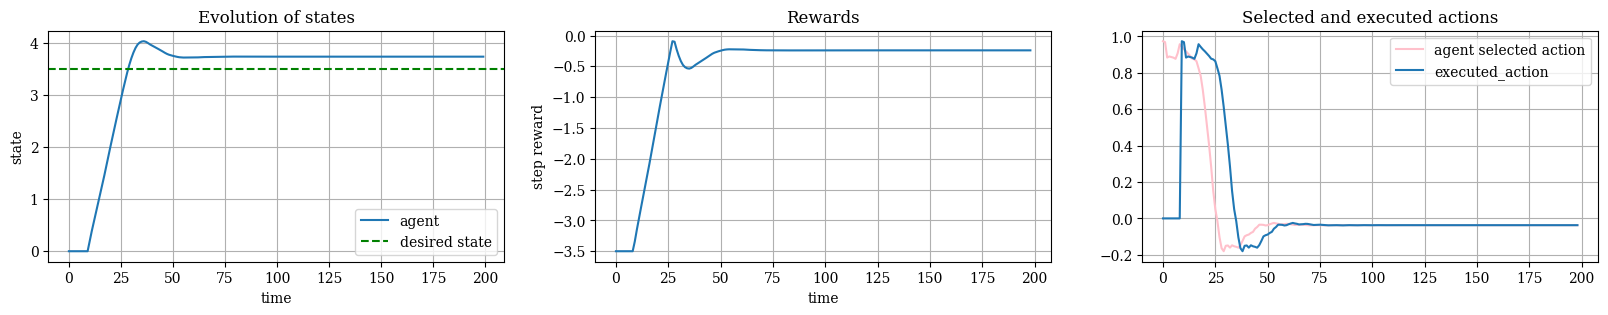

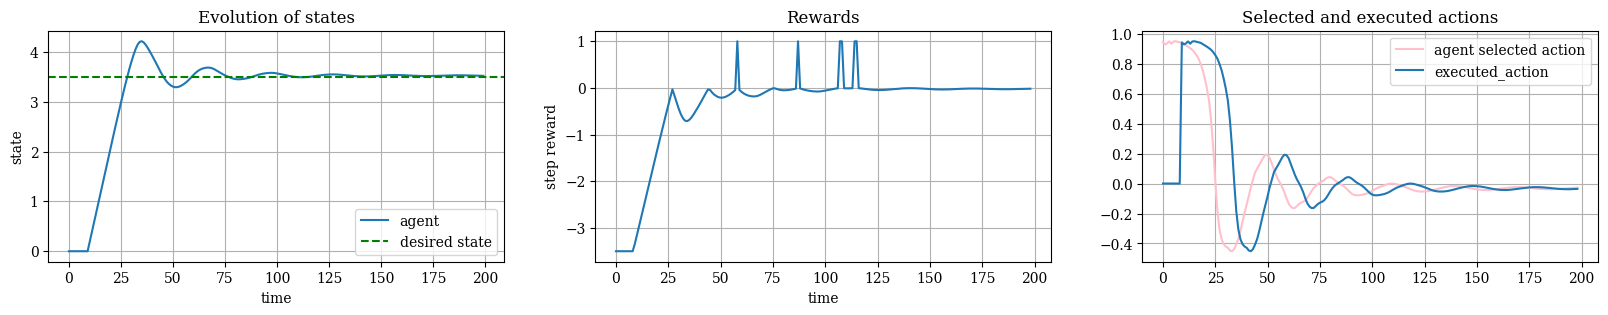

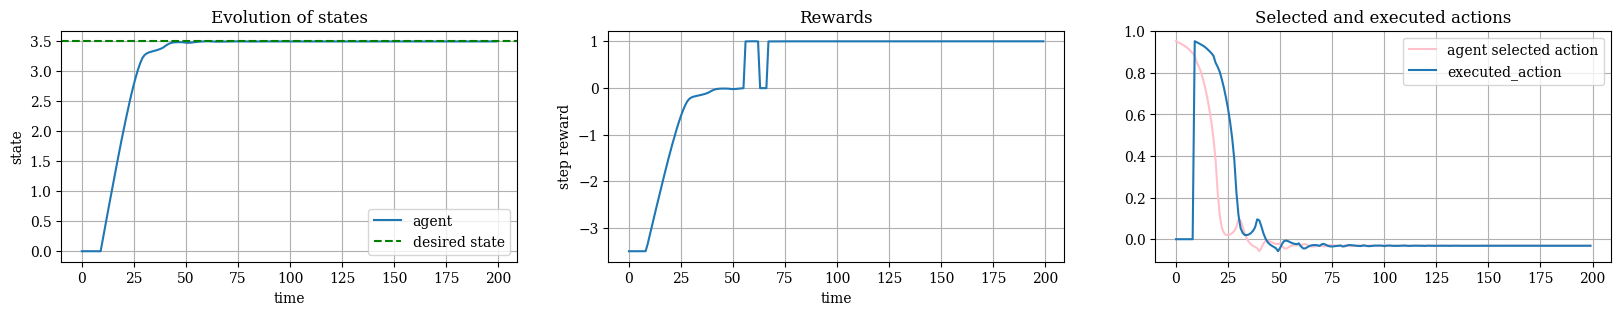

In [33]:
safe_agent = SAC.load('models\\NonLinearVelocity\\setpoint-error\\randomised\\Desired2.6142\\augsacsafe.zip')
core_env = NonLinearVelocity(start_state=np.array([0.0]), desired_state=np.array([3.5]), max_episode_len=200)

core_env = init_wrappers(core_env, observation_type='setpoint-error', randomise_setpoint=False)
env = DelayAction(core_env, delay = 9, random_delay=False, max_delay=global_config.MAX_DELAY)
env = AugmentState(env, known_delay=global_config.MAX_DELAY)

states, actions, rewards, avg_rewards, executed = test_augmented_agent(safe_agent, env, deterministic=True, state_error=True)
plot_test(env, states, rewards, actions, executed )

safe_agent = SAC.load('models\\NonLinearVelocity\\setpoint-error\\randomised\\Desired2.6143\\wcsac.zip')
states, actions, rewards, avg_rewards, executed = test_augmented_agent(safe_agent, env, deterministic=True, state_error=True)
plot_test(env, states, rewards, actions, executed )
# Test non-delayed agent
undelayed_agent = SAC.load('models\\NonLinearVelocity\\setpoint-error\\randomised\\Desired2.6143\\sac.zip')
states, actions, rewards, avg_rewards,executed = test_delayed_agent(undelayed_agent, env= env, 
                                                    env_model = copy.deepcopy(core_env), 
                                                    known_delay = 10,
                                                    deterministic = True, state_error= True)
plot_test(env, states, rewards, actions, executed )


## RobotSteer

In [98]:
core_env = RobotSteer(desired_state=np.array([0,1.0, 2.6141,0]))
wrapped = init_wrappers(core_env, observation_type='setpoint-error', randomise_setpoint=True)
print(f"Observation {wrapped.reset()[0]}, state {wrapped.unwrapped.state} and desired {wrapped.unwrapped.desired_state}")
tank_agent, tank_env = train_default_sac(core_env = core_env, 
                                         desired_state=[0,1.0,2.6141,0], 
                                         seed = 0, 
                                         n_episodes = 200, 
                                         observation_type='setpoint-error', 
                                         randomise_setpoint=True,
                                         rescale_observation = False)

Wrapping in random setpoint
Regions limits are [[array([-2.8       ,  0.2       ,  0.2       , -2.94159265]), array([-0.93333333,  1.73333333,  1.73333333, -0.98053088])], [array([-0.93333333,  1.73333333,  1.73333333, -0.98053088]), array([0.93333333, 3.26666667, 3.26666667, 0.98053088])], [array([0.93333333, 3.26666667, 3.26666667, 0.98053088]), array([2.8       , 4.8       , 4.8       , 2.94159265])]]
Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Observation [ 0.         -0.87804303 -0.54303125  0.          0.         -0.24158617
  0.16611735  0.        ], state [0.         1.51282328 0.31183513 0.        ] and desired [0.         0.30489242 1.14242187 0.        ]
Wrapping in random setpoint
Regions limits are [[array([-2.8       ,  0.2       ,  0.2       , -2.94159265]), array([-0.93333333,  1.73333333,  1.73333333, -0.98053088])], [array([-0.93333333,  1.73333333,  1.73333333, -0.98053088]), array([0.93333333, 3.26666667, 3.26666667, 0.98053088])], [arr

Wrapping in observe setpoint error
Rescaling action
Initial state was [0.  2.5 1.  0.  0.  2.5 1.  0. ]


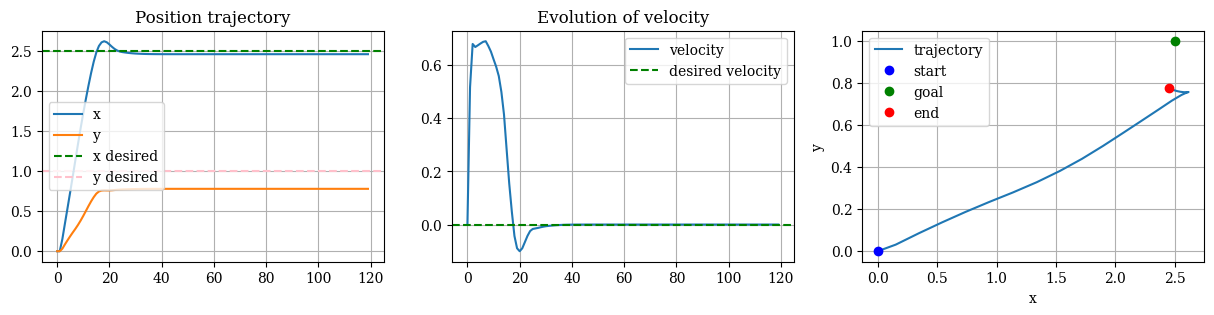

In [119]:
test_env = RobotSteer(desired_state=np.array([0, 2.5, 1.0,0]), start_state = np.array([0.0,0.0,0.0,0.0]))
test_env = init_wrappers(test_env, observation_type='setpoint-error', rescale_observation = False)
test_env = DelayAction(test_env, delay = 0)

states, actions, rewards, avg, executed = test_agent(tank_agent, test_env, deterministic=True, state_error=True)
plot_test(test_env,states, rewards,actions,executed)


In [120]:
setpoints = [2.6141,2.6142, 2.6143]
seeds = [0, 42, 96]
agent_types = ['wcsac', 'safesac', 'augsac']

for i, seed in enumerate(seeds) :
  setpoint = setpoints[i]
  core_env = RobotSteer(desired_state=np.array([0.0, setpoint, setpoint, 0.0]), seed = seed)
  agent, env = train_default_sac(core_env = core_env, 
                                 desired_state=[setpoint,setpoint], 
                                 seed = seed, 
                                 n_episodes = 200, 
                                 observation_type='setpoint-error', 
                                 randomise_setpoint=True)

  for agent_type in agent_types: 
    for avg_q in [True, False]:
      if avg_q == False and agent_type == 'augsac':
        continue
      
      safe_agent, env, delay_history, setpoint_history = train_default_augmented_sac(core_env = core_env, 
                                              agent_type= agent_type,
                                              desired_state= [setpoint,setpoint],
                                              seed = seed,
                                              observation_type='setpoint-error',
                                              randomise_setpoint=True, 
                                              random_delay=True,
                                              average_q=avg_q,
                                              n_episodes=200, 
                                              ent_coef=0.5,
                                              undelayed_critic=agent.critic)
      # min_str = 'min' if not avg_q else ''
      # np.save(f'histories/delay/RobotSteer/{agent_type}{min_str}_seed{seed}_setpoint{setpoint}', delay_history)
      # np.save(f'histories/setpoint/{agent_type}{min_str}_seed{seed}_setpoint{setpoint}', setpoint_history)
 





Wrapping in random setpoint
Regions limits are [[array([-2.8       ,  0.2       ,  0.2       , -2.94159265]), array([-0.93333333,  1.73333333,  1.73333333, -0.98053088])], [array([-0.93333333,  1.73333333,  1.73333333, -0.98053088]), array([0.93333333, 3.26666667, 3.26666667, 0.98053088])], [array([0.93333333, 3.26666667, 3.26666667, 0.98053088]), array([2.8       , 4.8       , 4.8       , 2.94159265])]]
Wrapping in observe setpoint error
Rescaling action
Rescaling observation
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/RobotSteer/setpoint-error/randomised/0615/Desired[2.6141, 2.6141]/sac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -583     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 31       |
|    time_elapsed    | 15       |
|    total_timesteps | 480      |
| train/             |    

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\RobotSteer\setpoint-error\randomised\Desired[2.6141, 2.6141]' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.state_space_violation to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state_space_violation` for environment variables or `env.get_wrapper_attr('state_space_violation')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -310     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 16       |
|    time_elapsed    | 29       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 4.15     |
|    critic_loss     | 0.388    |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -324     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 15       |
|    time_elapsed    | 62       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 8.31     |
|    critic_loss     | 0.133    |
|    ent_coef        | 0.5      |
|    learning_

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.delay_history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.delay_history` for environment variables or `env.get_wrapper_attr('delay_history')` that will search the reminding wrappers.
  logger.warn(
c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.desired_states_history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desired_states_history` for environment variables or `env.get_wrapper_attr('desired_states_history')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -365     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 15       |
|    time_elapsed    | 30       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 5.95     |
|    critic_loss     | 0.447    |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -377     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 14       |
|    time_elapsed    | 64       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 10.8     |
|    critic_loss     | 0.234    |
|    ent_coef        | 0.5      |
|    learning_

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\RobotSteer\setpoint-error\randomised\Desired[2.6142, 2.6142]' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -449     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 15       |
|    time_elapsed    | 30       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 7.1      |
|    critic_loss     | 0.264    |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -350     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 14       |
|    time_elapsed    | 67       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 10.6     |
|    critic_loss     | 0.194    |
|    ent_coef        | 0.5      |
|    learning_

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\RobotSteer\setpoint-error\randomised\Desired[2.6143, 2.6143]' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -429     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 15       |
|    time_elapsed    | 31       |
|    total_timesteps | 480      |
| train/             |          |
|    actor_loss      | 6.45     |
|    critic_loss     | 0.267    |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 379      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 120      |
|    ep_rew_mean     | -426     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 14       |
|    time_elapsed    | 68       |
|    total_timesteps | 960      |
| train/             |          |
|    actor_loss      | 10.7     |
|    critic_loss     | 0.215    |
|    ent_coef        | 0.5      |
|    learning_

In [7]:
setpoints = [2.6141, 2.6142, 2.6143]
dates = ['0614','0614','0615']
dates = ['0614','0614','0614']
# dates = ['0616','0616','0616']
agent_types = ['wcsac','wcsacmin','safesac','safesacmin','augsacsafe']

agent_dict = {}
for agent_type in agent_types:
    run_arr = []
    for i, setpoint in enumerate(setpoints) : 
        df = pd.read_csv(f'logs\\train\\RobotSteer\\setpoint-error\\randomised\\{dates[i]}\\Desired[{setpoint}, {setpoint}]\\{agent_type}\\progress.csv')
        run_arr.append(np.array(df['rollout/ep_rew_mean']))

    agent_dict[agent_type] = run_arr

# agent_dict

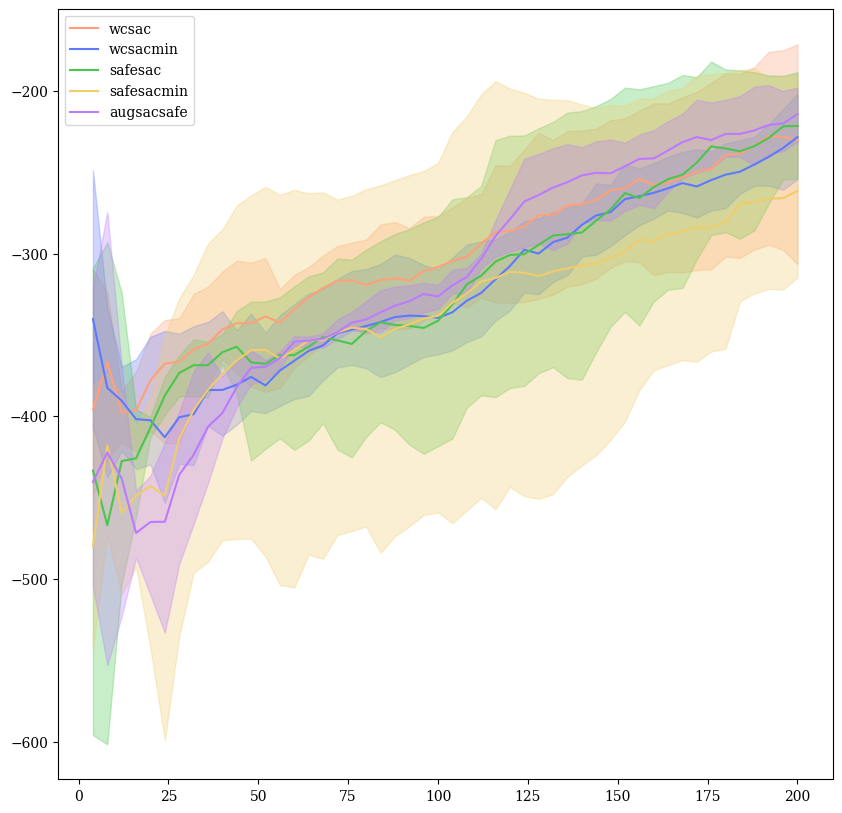

In [11]:
agent_types = ['wcsac','wcsacmin', 'safesac','safesacmin','augsacsafe']
colors = ['cold_orange', 'warm_blue', 'warm_green', 'warm_yellow', 'warm_purple','dark_pink']
# Plot 
f, ax = plt.subplots(1,1, figsize = (10,10))
for i, agent_type in enumerate(agent_types) : 
    res = np.array(agent_dict[agent_type])
    r_min = np.min(res, axis = 0)
    r_max = np.max(res, axis = 0)
    r_avg= np.mean(res, axis = 0)

    ax.plot(df['time/episodes'], r_avg, color = global_config.COLORS[colors[i]])
    ax.fill_between(df['time/episodes'], r_min, r_max, color = global_config.COLORS[colors[i]],  alpha = .3, label='_nolegend_')
# ax.legend([agent_types[i//2] if i%2 == 0 else '' for i in range(2*len(agent_types))]
ax.legend(agent_types)
